#### 特徴量が多次元の場合の線形回帰モデル

In [30]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import csv
from operator import itemgetter
import itertools

アルゴリズムの実装

In [2]:
class LinearRegression:
    def __init__(self):
        self.w_ = None

    def fit(self, X, t):
        Xtil = np.c_[np.ones(X.shape[0]), X]
        A = np.dot(Xtil.T, Xtil)
        b = np.dot(Xtil.T, t)
        self.w_ = linalg.solve(A, b)

    def predict(self, X):
        if X.ndim == 1:
            X = X.reshape(1, -1)
        Xtil = np.c_[np.ones(X.shape[0]), X]
        return np.dot(Xtil, self.w_)


人工的なデータで線形和の係数(1,2,3)を学習させる

係数： [1.11450326 1.95737004 3.00295751]
(1, 1)に対する予測値： [6.07483081]


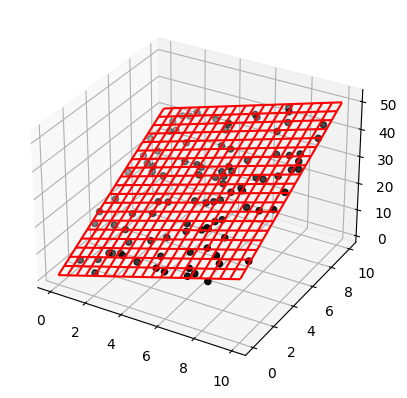

In [5]:
n = 100
scale = 10

np.random.seed(0)
X = np.random.random((n, 2)) * scale
w0 = 1
w1 = 2
w2 = 3
y = w0 + w1 * X[:, 0] + w2 * X[:, 1] + np.random.randn(n)

model = LinearRegression()
model.fit(X, y)
print("係数：", model.w_)
print("(1, 1)に対する予測値：", model.predict(np.array([1, 1])))

xmesh, ymesh = np.meshgrid(np.linspace(0, scale, 20),
                           np.linspace(0, scale, 20))
zmesh = (model.w_[0] + model.w_[1] * xmesh.ravel() +
         model.w_[2] * ymesh.ravel()).reshape(xmesh.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], y, color="k")
ax.plot_wireframe(xmesh, ymesh, zmesh, color="r")
plt.show()


ワインの品質予測（いつものデータ）

In [10]:
# データ読み込み
Xy = []
with open("C:\essenceofML\chapter5\winequality-red.csv") as fp:
    for row in csv.reader(fp, delimiter=";"):
        Xy.append(row)
Xy = np.array(Xy[1:], dtype=np.float64)

# 訓練用データとテスト用データに分割する
np.random.seed(0)
np.random.shuffle(Xy)
train_X = Xy[:-1000, :-1]
train_y = Xy[:-1000, -1]
test_X = Xy[-1000:, :-1]
test_y = Xy[-1000:, -1]
# 学習させる
model = LinearRegression()
model.fit(train_X, train_y)

# テスト用データにモデルを適用
y = model.predict(test_X)

print("最初の5つの正解と予測値:")
for i in range(5):
    print("{:1.0f} {:5.3f}".format(test_y[i], y[i]))
print()
print("RMSE:", np.sqrt(((test_y - y)**2).mean()))


最初の5つの正解と予測値:
7 6.012
6 5.734
5 5.285
8 6.352
5 5.414

RMSE: 0.6724248548467168


#### リッジ回帰
通常の目的関数に正則化項を追加する．
外れ値からの影響を受けにくい効果がある．

In [12]:
class RidgeRegression:
    def __init__(self, lambda_=1.):
        self.lambda_ = lambda_
        self.w_ = None

    def fit(self, X, t):
        Xtil = np.c_[np.ones(X.shape[0]), X]
        c = np.eye(Xtil.shape[1])
        A = np.dot(Xtil.T, Xtil) + self.lambda_ * c
        b = np.dot(Xtil.T, t)
        self.w_ = linalg.solve(A, b)

    def predict(self, X):
        Xtil = np.c_[np.ones(X.shape[0]), X]
        return np.dot(Xtil, self.w_)

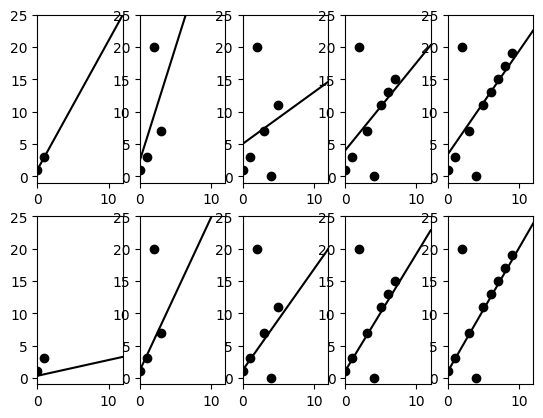

In [14]:
x = np.arange(12)
y = 1 + 2 * x
y[2] = 20
y[4] = 0

xmin = 0
xmax = 12
ymin = -1
ymax = 25
fig, axes = plt.subplots(nrows=2, ncols=5)
for i in range(5):
    axes[0, i].set_xlim([xmin, xmax])
    axes[0, i].set_ylim([ymin, ymax])
    axes[1, i].set_xlim([xmin, xmax])
    axes[1, i].set_ylim([ymin, ymax])
    xx = x[: 2 + i * 2]
    yy = y[: 2 + i * 2]
    axes[0, i].scatter(xx, yy, color="k")
    axes[1, i].scatter(xx, yy, color="k")
    model = LinearRegression()
    model.fit(xx, yy)
    xs = [xmin, xmax]
    ys = [model.w_[0] + model.w_[1] * xmin, model.w_[0] + model.w_[1] * xmax]
    axes[0, i].plot(xs, ys, color="k")
    model = RidgeRegression(10.)
    model.fit(xx, yy)
    xs = [xmin, xmax]
    ys = [model.w_[0] + model.w_[1] * xmin, model.w_[0] + model.w_[1] * xmax]
    axes[1, i].plot(xs, ys, color="k")


plt.show()


#### ラッソ回帰
正則化項としてL1ノルムを加える．
解を求めるアルゴリズムとしては座標降下法を使用．
先ほどと同様のWineQualityのデータを使用して，ハイパーパラメータを変化させながらその精度を評価．

In [15]:
def soft_thresholding(x, y):
    return np.sign(x) * max(abs(x) - y, 0)


class Lasso:
    def __init__(self, lambda_, tol=0.0001, max_iter=1000):
        self.lambda_ = lambda_
        self.tol = tol
        self.max_iter = max_iter
        self.w_ = None

    def fit(self, X, t):
        n, d = X.shape
        self.w_ = np.zeros(d + 1)
        avgl1 = 0.
        for _ in range(self.max_iter):
            avgl1_prev = avgl1
            self._update(n, d, X, t)
            avgl1 = np.abs(self.w_).sum() / self.w_.shape[0]
            if abs(avgl1 - avgl1_prev) <= self.tol:
                break

    def _update(self, n, d, X, t):
        self.w_[0] = (t - np.dot(X, self.w_[1:])).sum() / n
        w0vec = np.ones(n) * self.w_[0]
        for k in range(d):
            ww = self.w_[1:]
            ww[k] = 0
            q = np.dot(t - w0vec - np.dot(X, ww), X[:, k])
            r = np.dot(X[:, k], X[:, k])
            self.w_[k + 1] = soft_thresholding(q / r, self.lambda_)

    def predict(self, X):
        if X.ndim == 1:
            X = X.reshape(X.shape[0], 1)
        Xtil = np.c_[np.ones(X.shape[0]), X]
        return np.dot(Xtil, self.w_)

In [17]:
# データ読み込み
Xy = []
with open("C:\essenceofML\chapter5\winequality-red.csv") as fp:
    for row in csv.reader(fp, delimiter=";"):
        Xy.append(row)
Xy = np.array(Xy[1:], dtype=np.float64)

# 訓練用データとテスト用データに分割する
np.random.seed(0)
np.random.shuffle(Xy)
train_X = Xy[:-1000, :-1]
train_y = Xy[:-1000, -1]
test_X = Xy[-1000:, :-1]
test_y = Xy[-1000:, -1]

# ハイパーパラメータを変えながら学習させて結果表示
for lambda_ in [1., 0.1, 0.01]:
    model = Lasso(lambda_)
    model.fit(train_X, train_y)
    y = model.predict(test_X)
    print("--- lambda = {} ---".format(lambda_))
    print("coefficients:")
    print(model.w_)
    mse = ((y - test_y)**2).mean()
    print("MSE: {:.3f}".format(mse))

--- lambda = 1.0 ---
coefficients:
[ 5.58430718  0.         -0.          0.          0.         -0.
  0.         -0.         -0.         -0.          0.          0.        ]
MSE: 0.691
--- lambda = 0.1 ---
coefficients:
[ 5.73493612  0.         -0.1407455   0.34369322 -0.         -2.00071813
  0.         -0.         -0.          0.          0.          0.        ]
MSE: 0.636
--- lambda = 0.01 ---
coefficients:
[ 5.71424724  0.         -1.01439751  0.00742223  0.         -3.34228417
  0.         -0.          0.          0.          1.04248618  0.        ]
MSE: 0.539


#### ロジスティック回帰
二値分類に用いる手法．
検査数値と乳がんの診断結果のデータから訓練と，評価を行う．

In [18]:
THRESHMIN = 1e-10


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


class LogisticRegression:
    def __init__(self, tol=0.001, max_iter=3, random_seed=0):
        self.tol = tol
        self.max_iter = max_iter
        self.random_state = np.random.RandomState(random_seed)
        self.w_ = None

    def fit(self, X, y):
        self.w_ = self.random_state.randn(X.shape[1] + 1)
        Xtil = np.c_[np.ones(X.shape[0]), X]
        diff = np.inf
        w_prev = self.w_
        iter = 0
        while diff > self.tol and iter < self.max_iter:
            yhat = sigmoid(np.dot(Xtil, self.w_))
            r = np.clip(yhat * (1 - yhat),
                        THRESHMIN, np.inf)
            XR = Xtil.T * r
            XRX = np.dot(Xtil.T * r, Xtil)
            w_prev = self.w_
            b = np.dot(XR, np.dot(Xtil, self.w_) -
                       1 / r * (yhat - y))
            self.w_ = linalg.solve(XRX, b)
            diff = abs(w_prev - self.w_).mean()
            iter += 1

    def predict(self, X):
        Xtil = np.c_[np.ones(X.shape[0]), X]
        yhat = sigmoid(np.dot(Xtil, self.w_))
        return np.where(yhat > .5, 1, 0)

In [20]:
n_test = 100
X = []
y = []
with open("C:\essenceofML\chapter5\wdbc.data") as fp:
    for row in csv.reader(fp):
        if row[1] == "B":
            y.append(0)
        else:
            y.append(1)
        X.append(row[2:])

y = np.array(y, dtype=np.float64)
X = np.array(X, dtype=np.float64)
y_train = y[:-n_test]
X_train = X[:-n_test]
y_test = y[-n_test:]
X_test = X[-n_test:]
model = LogisticRegression(tol=0.01)
model.fit(X_train, y_train)

y_predict = model.predict(X_test)
n_hits = (y_test == y_predict).sum()
print("Accuracy: {}/{} = {}".format(n_hits, n_test, n_hits / n_test))

Accuracy: 97/100 = 0.97


C:\Users\523m2\AppData\Local\Temp\ipykernel_23300\744090874.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


#### サポートベクタマシン
超平面と超曲面(カーネル法)での2つのクラスの分類を実装．

In [21]:
class SVC:
    def __init__(self, C=1.):
        self.C = C

    def fit(self, X, y, selections=None):
        a = np.zeros(X.shape[0])
        ay = 0
        ayx = np.zeros(X.shape[1])
        yx = y.reshape(-1, 1)*X
        indices = np.arange(X.shape[0])
        while True:
            ydf = y*(1-np.dot(yx, ayx.T))
            iydf = np.c_[indices, ydf]
            i = int(min(iydf[((a > 0) & (y > 0)) |
                             ((a < self.C) & (y < 0))],
                        key=itemgetter(1))[0])
            j = int(max(iydf[((a > 0) & (y < 0)) |
                             ((a < self.C) & (y > 0))],
                        key=itemgetter(1))[0])
            if ydf[i] >= ydf[j]:
                break
            ay2 = ay - y[i]*a[i] - y[j]*a[j]
            ayx2 = ayx - y[i]*a[i]*X[i, :] - y[j]*a[j]*X[j, :]
            ai = ((1-y[i]*y[j]
                   + y[i]*np.dot(X[i, :] - X[j, :],
                                 X[j, :]*ay2 - ayx2))
                  / ((X[i] - X[j])**2).sum())
            if ai < 0:
                ai = 0
            elif ai > self.C:
                ai = self.C
            aj = (-ai * y[i] - ay2) * y[j]
            if aj < 0:
                aj = 0
                ai = (-aj*y[j]-ay2)*y[i]
            elif aj > self.C:
                aj = self.C
                ai = (-aj*y[j]-ay2)*y[i]
            ay += y[i]*(ai - a[i]) + y[j]*(aj - a[j])
            ayx += y[i]*(ai - a[i])*X[i, :] + y[j]*(aj - a[j])*X[j, :]
            if ai == a[i]:
                break
            a[i] = ai
            a[j] = aj
        self.a_ = a
        ind = a != 0.
        self.w_ = ((a[ind] * y[ind]).reshape(-1, 1)
                   * X[ind, :]).sum(axis=0)
        self.w0_ = (y[ind]
                    - np.dot(X[ind, :], self.w_)).sum() / ind.sum()

    def predict(self, X):
        return np.sign(self.w0_ + np.dot(X, self.w_))


正しく分類できた数: 37


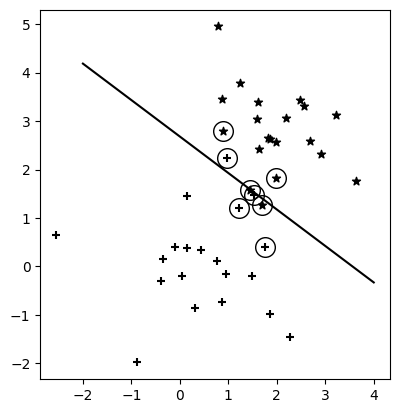

In [25]:

plt.axes().set_aspect("equal")
np.random.seed(0)
X0 = np.random.randn(20, 2)
X1 = np.random.randn(20, 2) + np.array([2.5, 3])
y = np.array([1] * 20 + [-1] * 20)

X = np.r_[X0, X1]

model = SVC()
model.fit(X, y)

plt.scatter(X0[:, 0], X0[:, 1], color="k", marker="+")
plt.scatter(X1[:, 0], X1[:, 1], color="k", marker="*")


def f(model, x):
    return (-model.w0_ - model.w_[0] * x) / model.w_[1]


x1 = -2
x2 = 4
plt.plot([x1, x2], [f(model, x1), f(model, x2)], color="k")
print("正しく分類できた数:", (model.predict(X) == y).sum())
plt.scatter(X[model.a_ != 0, 0], X[model.a_ != 0, 1],
            s=200, color=(0, 0, 0, 0), edgecolor="k", marker="o")


def f(model, xx):
    return model.w0_+np.dot(model.w_, xx)


plt.show()


In [26]:
class RBFKernel:
    def __init__(self, X, sigma):
        self.sigma2 = sigma**2
        self.X = X
        self.values_ = np.empty((X.shape[0], X.shape[0]))

    def value(self, i, j):
        return np.exp(-((self.X[i, :] - self.X[j, :])**2).sum()
                      / (2*self.sigma2))

    def eval(self, Z, s):
        return np.exp(-((self.X[s, np.newaxis, :]
                         - Z[np.newaxis, :, :])**2).sum(axis=2)
                      / (2*self.sigma2))


class SVC:
    def __init__(self, C=1., sigma=1., max_iter=10000):
        self.C = C
        self.sigma = sigma
        self.max_iter = max_iter

    def fit(self, X, y, selections=None):
        a = np.zeros(X.shape[0])
        ay = 0
        kernel = RBFKernel(X, self.sigma)
        indices = np.arange(X.shape[0])
        for _ in range(self.max_iter):
            s = a != 0.
            ydf = y * (1 - y*np.dot(a[s]*y[s],
                                    kernel.eval(X, s)).T)
            iydf = np.c_[indices, ydf]
            i = int(min(iydf[((a > 0) & (y > 0)) |
                             ((a < self.C) & (y < 0))],
                        key=itemgetter(1))[0])
            j = int(max(iydf[((a > 0) & (y < 0)) |
                             ((a < self.C) & (y > 0))],
                        key=itemgetter(1))[0])
            if ydf[i] >= ydf[j]:
                break
            ay2 = ay - y[i]*a[i] - y[j]*a[j]
            kii = kernel.value(i, i)
            kij = kernel.value(i, j)
            kjj = kernel.value(j, j)
            s = a != 0.
            s[i] = False
            s[j] = False
            kxi = kernel.eval(X[i, :].reshape(1, -1), s).ravel()
            kxj = kernel.eval(X[j, :].reshape(1, -1), s).ravel()
            ai = ((1 - y[i]*y[j]
                   + y[i]*((kij - kjj)*ay2
                           - (a[s]*y[s]*(kxi-kxj)).sum()))
                  / (kii + kjj - 2*kij))
            if ai < 0:
                ai = 0
            elif ai > self.C:
                ai = self.C
            aj = (-ai*y[i] - ay2)*y[j]
            if aj < 0:
                aj = 0
                ai = (-aj*y[j] - ay2)*y[i]
            elif aj > self.C:
                aj = self.C
                ai = (-aj*y[j] - ay2)*y[i]
            ay += y[i] * (ai-a[i]) + y[j] * (aj-a[j])
            if ai == a[i]:
                break
            a[i] = ai
            a[j] = aj
        self.a_ = a
        self.y_ = y
        self.kernel_ = kernel
        s = a != 0.
        self.w0_ = (y[s]
                    - np.dot(a[s]*y[s],
                             kernel.eval(X[s], s))).sum() / s.sum()
        with open("svm.log", "w") as fp:
            print(a, file=fp)

    def predict(self, X):
        s = self.a_ != 0.
        return np.sign(self.w0_
                       + np.dot(self.a_[s]*self.y_[s],
                                self.kernel_.eval(X, s)))

正しく分類できた数: 193


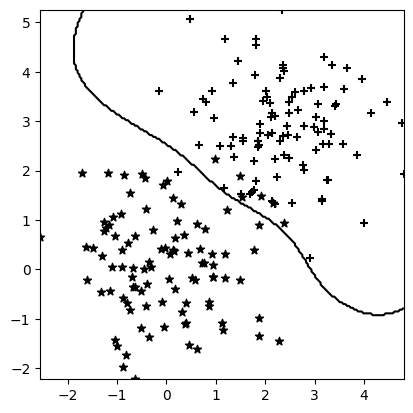

In [28]:
plt.axes().set_aspect("equal")
np.random.seed(0)
X0 = np.random.randn(100, 2)
X1 = np.random.randn(100, 2) + np.array([2.5, 3])
y = np.array([1] * 100 + [-1] * 100)
X = np.r_[X0, X1]

model = SVC()
model.fit(X, y)

xmin, xmax = X[:, 0].min(), X[:, 0].max()
ymin, ymax = X[:, 1].min(), X[:, 1].max()

plt.scatter(X0[:, 0], X0[:, 1], color="k", marker="*")
plt.scatter(X1[:, 0], X1[:, 1], color="k", marker="+")
xmesh, ymesh = np.meshgrid(np.linspace(xmin, xmax, 200),
                           np.linspace(ymin, ymax, 200))
Z = model.predict(np.c_[xmesh.ravel(), ymesh.ravel()]).reshape(xmesh.shape)
plt.contour(xmesh, ymesh, Z, levels=[0], colors="k")

print("正しく分類できた数:", (model.predict(X) == y).sum())
plt.show()

## 教師なし学習
#### k-Means法
クラスタリングのアルゴリズムである．
中心をずらして発生させた人工的な3つの点群をクラス分け．

In [29]:
class KMeans:
    def __init__(self, n_clusters, max_iter=1000, random_seed=0):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = np.random.RandomState(random_seed)

    def fit(self, X):
        cycle = itertools.cycle(range(self.n_clusters))
        self.labels_ = np.fromiter(
            itertools.islice(cycle, X.shape[0]), dtype=int)
        self.random_state.shuffle(self.labels_)
        labels_prev = np.zeros(X.shape[0])
        count = 0
        self.cluster_centers_ = np.zeros(
            (self.n_clusters, X.shape[1]))
        while (not (self.labels_ == labels_prev).all()
               and count < self.max_iter):
            for i in range(self.n_clusters):
                XX = X[self.labels_ == i, :]
                self.cluster_centers_[i, :] = XX.mean(axis=0)
            dist = ((X[:, :, np.newaxis]
                     - self.cluster_centers_.T[np.newaxis, :, :])
                    ** 2).sum(axis=1)
            labels_prev = self.labels_
            self.labels_ = dist.argmin(axis=1)
            count += 1

    def predict(self, X):
        dist = ((X[:, :, np.newaxis]
                 - self.cluster_centers_.T[np.newaxis, :, :])
                ** 2).sum(axis=1)
        labels = dist.argmin(axis=1)
        return labels


[[4.98947    0.22283884]
 [0.01680616 0.10280987]
 [4.8968835  5.03067405]] 3


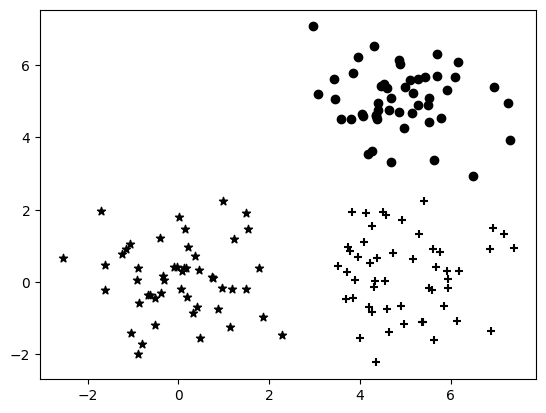

In [31]:
np.random.seed(0)
points1 = np.random.randn(50, 2)
points2 = np.random.randn(50, 2) + np.array([5, 0])
points3 = np.random.randn(50, 2) + np.array([5, 5])

points = np.r_[points1, points2, points3]
np.random.shuffle(points)

model = KMeans(3)
model.fit(points)

markers = ["+", "*", "o"]
for i in range(3):
    p = points[model.labels_ == i, :]
    plt.scatter(p[:, 0], p[:, 1], color="k", marker=markers[i])

print(model.cluster_centers_,model.n_clusters)
plt.show()


#### 主成分分析